In [17]:
from datascience import *
%matplotlib inline
path_data = '../../../../data/'
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import numpy as np

### Deflategate ###
On January 18, 2015, the Indianapolis Colts and the New England Patriots played the American Football Conference (AFC) championship game to determine which of those teams would play in the Super Bowl. After the game, there were allegations that the Patriots' footballs had not been inflated as much as the regulations required; they were softer. This could be an advantage, as softer balls might be easier to catch.

For several weeks, the world of American football was consumed by accusations, denials, theories, and suspicions: the press labeled the topic Deflategate, after the Watergate political scandal of the 1970's. The National Football League (NFL) commissioned an independent analysis. In this example, we will perform our own analysis of the data.

Pressure is often measured in pounds per square inch (psi). NFL rules stipulate that game balls must be inflated to have pressures in the range 12.5 psi and 13.5 psi. Each team plays with 12 balls. Teams have the responsibility of maintaining the pressure in their own footballs, but game officials inspect the balls. Before the start of the AFC game, all the Patriots' balls were at about 12.5 psi. Most of the Colts' balls were at about 13.0 psi. However, these pre-game data were not recorded.

During the second quarter, the Colts intercepted a Patriots ball. On the sidelines, they measured the pressure of the ball and determined that it was below the 12.5 psi threshold. Promptly, they informed officials. 

At half-time, all the game balls were collected for inspection. Two officials, Clete Blakeman and Dyrol Prioleau, measured the pressure in each of the balls. 

Here are the data. Each row corresponds to one football. Pressure is measured in psi. The Patriots ball that had been intercepted by the Colts was not inspected at half-time. Nor were most of the Colts' balls – the officials simply ran out of time and had to relinquish the balls for the start of second half play.

In [18]:
football = Table.read_table(path_data + 'deflategate.csv')
football.show()

Team,Blakeman,Prioleau
Patriots,11.5,11.8
Patriots,10.85,11.2
Patriots,11.15,11.5
Patriots,10.7,11
Patriots,11.1,11.45
Patriots,11.6,11.95
Patriots,11.85,12.3
Patriots,11.1,11.55
Patriots,10.95,11.35
Patriots,10.5,10.9


For each of the 15 balls that were inspected, the two officials got different results. It is not uncommon that repeated measurements on the same object yield different results, especially when the measurements are performed by different people. So we will assign to each the ball the average of the two measurements made on that ball.

In [19]:
football = football.with_column(
    'Combined', (football.column(1)+football.column(2))/2
    ).drop(1, 2)
football.show()

Team,Combined
Patriots,11.65
Patriots,11.025
Patriots,11.325
Patriots,10.85
Patriots,11.275
Patriots,11.775
Patriots,12.075
Patriots,11.325
Patriots,11.15
Patriots,10.7


At a glance, it seems apparent that the Patriots' footballs were at a lower pressure than the Colts' balls. Because some deflation is normal during the course of a game, the independent analysts decided to calculate the drop in pressure from the start of the game. Recall that the Patriots' balls had all started out at about 12.5 psi, and the Colts' balls at about 13.0 psi. Therefore the drop in pressure for the Patriots' balls was computed as 12.5 minus the pressure at half-time, and the drop in pressure for the Colts' balls was 13.0 minus the pressure at half-time.

We can calculate the drop in pressure for each football, by first setting up an array of the starting values. For this we will need an array consisting of 11 values each of which is 12.5, and another consisting of four values each of which is all 13. We will use the NumPy function `np.ones`, which takes a count as its argument and returns an array of that many elements, each of which is 1.

In [20]:
np.ones(11)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [21]:
patriots_start = 12.5 * np.ones(11)
colts_start = 13 * np.ones(4)
start = np.append(patriots_start, colts_start)
start

array([12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5,
       13. , 13. , 13. , 13. ])

The drop in pressure for each football is the difference between the starting pressure and the combined pressure measurement.

In [22]:
drop = start - football.column('Combined')
football = football.with_column('Pressure Drop', drop)
football.show()

Team,Combined,Pressure Drop
Patriots,11.65,0.85
Patriots,11.025,1.475
Patriots,11.325,1.175
Patriots,10.85,1.65
Patriots,11.275,1.225
Patriots,11.775,0.725
Patriots,12.075,0.425
Patriots,11.325,1.175
Patriots,11.15,1.35
Patriots,10.7,1.8


It looks as though the Patriots' drops were larger than the Colts'. Let's look at the average drop in each of the two groups. We no longer need the combined scores.

In [23]:
football = football.drop('Combined')
football.group('Team', np.average)

Team,Pressure Drop average
Colts,0.46875
Patriots,1.20227


The average drop for the Patriots was about 1.2 psi compared to about 0.47 psi for the Colts. 

The question now is why the Patriots' footballs had a larger drop in pressure, on average, than the Colts footballs. Could it be due to chance?

### The Hypotheses ###
How does chance come in here? Nothing was being selected at random. But we can make a chance model by hypothesizing that the 11 Patriots' drops look like a random sample of 11 out of all the 15 drops, with the Colts' drops being the remaining four. That's a completely specified chance model under which we can simulate data. So it's the **null hypothesis**.

For the alternative, we can take the position that the Patriots' drops are too large, on average, to resemble a random sample drawn from all the drops. 

### Test Statistic ###
A natural statistic is the difference between the two average drops, which we will compute as "average drop for Patriots - average drop for Colts". Large values of this statistic will favor the alternative hypothesis.

In [24]:
observed_means = football.group('Team', np.average).column(1)

observed_difference = observed_means.item(1) - observed_means.item(0)
observed_difference

0.733522727272728

This positive difference reflects the fact that the average drop in pressure of the Patriots' footballs was greater than that of the Colts.

The function `difference_of_means` takes three arguments:

- the name of the table of data
- the label of the column containing the numerical variable whose average is of interest
- the label of the column containing the two group labels

It returns the difference between the means of the two groups. 

We have defined this function in an earlier section. The definition is repeated here for ease of reference.

In [25]:
def difference_of_means(table, label, group_label):
    reduced = table.select(label, group_label)
    means_table = reduced.group(group_label, np.average)
    means = means_table.column(1)
    return means.item(1) - means.item(0)

In [26]:
difference_of_means(football, 'Pressure Drop', 'Team')

0.733522727272728

Notice that the difference has been calculated as Patriots' drops minus Colts' drops as before.

### Predicting the Statistic Under the Null Hypothesis ###
If the null hypothesis were true, then it shouldn't matter which footballs are labeled Patriots and which are labeled Colts. The distributions of the two sets of drops would be the same. We can simulate this by randomly shuffling the team labels.

In [39]:
shuffled_labels = football.sample(with_replacement=False).column(0)
original_and_shuffled = football.with_column('Shuffled Label', shuffled_labels)
original_and_shuffled.show()

Team,Pressure Drop,Shuffled Label
Patriots,0.85,Colts
Patriots,1.475,Patriots
Patriots,1.175,Patriots
Patriots,1.65,Patriots
Patriots,1.225,Patriots
Patriots,0.725,Patriots
Patriots,0.425,Patriots
Patriots,1.175,Colts
Patriots,1.35,Patriots
Patriots,1.8,Patriots


How do all the group averages compare?

In [40]:
difference_of_means(original_and_shuffled, 'Pressure Drop', 'Shuffled Label')

0.11988636363636407

In [32]:
difference_of_means(original_and_shuffled, 'Pressure Drop', 'Team')

0.733522727272728

The two teams' average drop values are closer when the team labels are randomly assigned to the footballs than they were for the two groups actually used in the game.

### Permutation Test ###
It's time for a step that is now familiar. We will do repeated simulations of the test statistic under the null hypothesis, by repeatedly permuting the footballs and assigning random sets to the two teams.

Once again, we will use the function `one_simulated_difference` defined in an earlier section as follows.

In [33]:
def one_simulated_difference(table, label, group_label):
    shuffled_labels = table.sample(with_replacement = False
                                                    ).column(group_label)
    shuffled_table = table.select(label).with_column(
        'Shuffled Label', shuffled_labels)
    return difference_of_means(shuffled_table, label, 'Shuffled Label')   

We can now use this function to create an array `differences` that contains 10,000 values of the test statistic simulated under the null hypothesis.

In [36]:
differences = make_array()

repetitions = 10000
for i in np.arange(repetitions):
    new_difference = one_simulated_difference(football, 'Pressure Drop', 'Team')
    differences = np.append(differences, new_difference)

### Conclusion of the Test ###
To calculate the empirical P-value, it's important to recall the alternative hypothesis, which is that the Patriots' drops are too large to be the result of chance variation alone.

Larger drops for the Patriots favor the alternative hypothesis. So the P-value is the chance (computed under the null hypothesis) of getting a test statistic equal to our observed value of 0.733522727272728 or larger.

In [37]:
empirical_P = np.count_nonzero(differences >= observed_difference) / 10000
empirical_P

0.0043

That's a pretty small P-value. To visualize this, here is the empirical distribution of the test statistic under the null hypothesis, with the observed statistic marked on the horizontal axis.

Observed Difference: 0.733522727272728
Empirical P-value: 0.0043


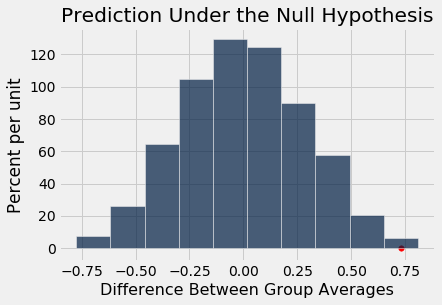

In [38]:
Table().with_column('Difference Between Group Averages', differences).hist()
plots.scatter(observed_difference, 0, color='red', s=30)
plots.title('Prediction Under the Null Hypothesis')
print('Observed Difference:', observed_difference)
print('Empirical P-value:', empirical_P)

As in previous examples of this test, the bulk of the distribution is centered around 0. Under the null hypothesis, the Patriots' drops are a random sample of all 15 drops, and therefore so are the Colts'. Therefore the two sets of drops should be about equal on average, and therefore their difference should be around 0.

But the observed value of the test statistic is quite far away from the heart of the distribution. By any reasonable cutoff for what is "small", the empirical P-value is small. So we end up rejecting the null hypothesis of randomness, and conclude that the Patriots drops were too large to reflect chance variation alone.

The independent investigative team analyzed the data in several different ways, taking into account the laws of physics. The final report said, 

> "[T]he average pressure drop of the Patriots game balls exceeded the average pressure drop of the Colts balls by 0.45 to 1.02 psi, depending on various possible assumptions regarding the gauges used, and assuming an initial pressure of 12.5 psi for the Patriots balls and 13.0 for the Colts balls."
> 
> -- *Investigative report commissioned by the NFL regarding the AFC Championship game on January 18, 2015*

Our analysis shows an average pressure drop of about 0.73 psi, which is close to the center of the interval "0.45 to 1.02 psi" and therefore consistent with the official analysis.

Remember that our test of hypotheses does not establish the reason *why* the difference is not due to chance. Establishing causality is usually more complex than running a test of hypotheses.

But the all-important question in the football world was about causation: the question was whether the excess drop of pressure in the Patriots' footballs was deliberate. If you are curious about the answer given by the investigators, here is the [full report](https://nfllabor.files.wordpress.com/2015/05/investigative-and-expert-reports-re-footballs-used-during-afc-championsh.pdf).